# Movie Dataset Analysis

This is an exploratory analysis on a movie dataset. Fields include `Title`, `Genre`, `Stars`, `Runtime`, `Budget`, `Promo`, `Season`, `Rating`, the reviews of three reviewers, and a target variable of `Success` which tells if the film succeeded or not.

In [2]:
import pandas as pd
df = pd.read_csv("movie_data.csv")

# Data Cleaning

I cleaned the following issues in the dataset:
- *Extraordinarily large numbers in `Budget` column* -- I assumed that these extraordinarily large numbers all described the movie budget in dollars rather than millions of dollars. I detected these numbers by converting them to a string, and then matching them against a regex that detected 1-3 digits, followed by a period, followed by any number of digits. Anything that did not match I opted to fix, as I thought it was unreasonable for a movie to have a budget of over \$1000M. I fixed these numbers by dividing them by a million and replacing the old value in the column with this. I chose to do this because after inspecting the numbers that did not match the regex, they seemed to be all in the millions, which led me to the first assumption.
- *Zeroes in `Runtime` column* -- I used mean imputation to fix this. I calculated the mean across all entries in this series that were not 0, then replaced each 0 with it. I chose mean imputation because there were drawbacks to other methods. In the case of hot-deck imputation, each data row seemed too complex to find a separate row that was most similar to it. In the case of Bayesian imputation, Pandas does not have an easy way to implement this. Finally, since I assume the `Runtime` values are rounded versions of continuous data, median and mode do not seem like the most fitting measures of central tendency.
- *Large numbers in `Stars` column* -- I used median imputation to fix this. I first used the Pandas `unique()` method to find each value present in this series, and it returned an array with the numbers 0-5 as well as 100. I then replaced each 100 with the median calculated from all of the other numbers. I chose median imputation because there were drawbacks to other methods. I opted not to use hot-deck nor Bayesian imputation for the same reasons outlined in the above bullet point, and I thought the median was the best measure of central tendency for this series because its data is ordinal rather than continuous or categorical.

In [3]:
# Fix 1: fixing extraordinarily large values in budget column
import re
def convert_to_millions(s):
    match = re.search('^\d{1,3}\.\d+$', str(s))
    if not match:
        # assume the current value is in dollars, not millions of dollars
        return int(s)/1000000
    else:
        return s

df["Budget"] = df["Budget"].apply(convert_to_millions)
#print(df["Budget"].max())

In [4]:
# Fix 2: imputing 0's in runtime column with mean
runtime_mean = round(df[df["Runtime"] != 0]["Runtime"].mean())
df["Runtime"] = df["Runtime"].replace({0: runtime_mean})

In [5]:
# Fix 3: imputing extraordinarily large values in stars column with mean
#print(df["Stars"].unique())
stars_median = round(df[df["Stars"] != 100]["Stars"].median())
df["Stars"] = df["Stars"].replace({100: stars_median})

# Data Exploration





In [6]:
import scipy as sp
crosstab = pd.crosstab(df['Season'], df['Success'])
crosstab

Success,False,True
Season,,
Fall,90,23
Spring,88,10
Summer,149,58
Winter,95,27


In [7]:
chi2_res = sp.stats.chi2_contingency(crosstab)
chi2_res.pvalue

0.005716268505111858

Season has a statistically significant impact on a movie's success.
**p-value:** $\approx 0.006$

In [8]:
crosstab2 = pd.crosstab(df['Season'], df['Rating'])
crosstab2

Rating,PG,PG13,R
Season,,,
Fall,42,38,33
Spring,33,35,30
Summer,64,71,72
Winter,55,39,28


In [9]:
chi2_res2 = sp.stats.chi2_contingency(crosstab2)
chi2_res2.pvalue

0.21507814500508263

Seasons do not have statistically significant distributions of ratings. **p-value:** $\approx 0.215$

In [10]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ltfx/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
analyzer = SentimentIntensityAnalyzer()

for reviewer in ["R1", "R2", "R3"]:
    total_reviews, negative_reviews = 0, 0
    for review in df[reviewer]:
        total_reviews += 1
        # return a dictionary with positive/negative/neutral elements of the sentence as judged by the nltk analyzer
        # overall rating (between -1, 1) is tied to 'compound' key, use convention that < -0.05 is negative 
        # (> -0.05 and < 0.05 is neutral)
        current_score = analyzer.polarity_scores(review)
        if current_score["compound"] < -0.05:
            negative_reviews += 1
    print(f"{reviewer}: {negative_reviews/total_reviews}")

R1: 0.5018518518518519
R2: 0.38333333333333336
R3: 0.32037037037037036


Reviewer 1 is the harshest critic, with the highest percentage of negative reviews.

In [12]:
promo = df["Promo"]
budget = df["Budget"]
promo.cov(budget)

1907.0543229973102

Covariance between promotional budget and the filming budget: $\approx 1907.05$

# Data Visualization

Visualizing the budget distribution based on the number of stars in the movie:

Text(0.5, 1.0, 'Distribution of Movie Budgets by Number of Movie Stars')

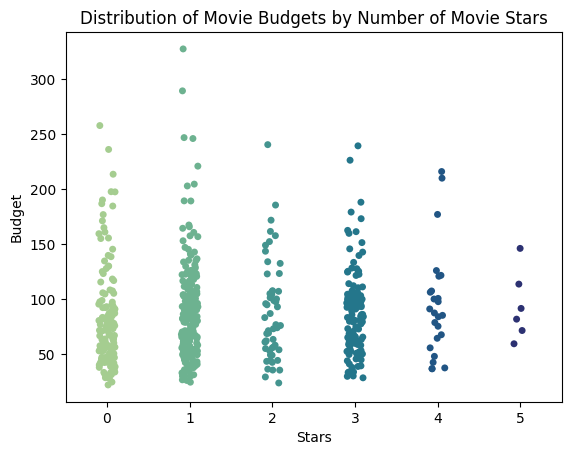

In [13]:
import seaborn as sns
stripplot = sns.stripplot(data=df, x="Stars", y="Budget", palette="crest", hue="Stars", legend=False)
stripplot.set_title("Distribution of Movie Budgets by Number of Movie Stars")

Visualizing average movie budget over time:

Text(0, 0.5, 'Average budget (USD, millions)')

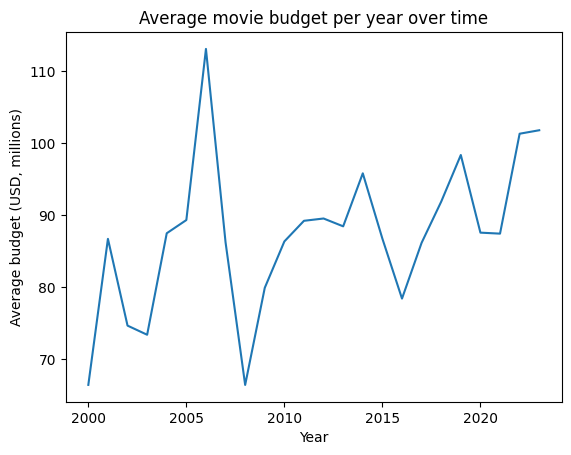

In [14]:
means = df.groupby('Year')['Budget'].mean()
df2 = means.reset_index(name='Average budget')
lineplot = sns.lineplot(data=df2, x="Year", y="Average budget")
lineplot.set_title("Average movie budget per year over time")
lineplot.set_ylabel("Average budget (USD, millions)")

# Feature Engineering

I did the following to the data in order to make the data easier for my model to analyze:
- Added features to quantify how positive each of the reviewers' reviews for a given movie were. I named these features `R1 Positivity`, `R2 Positivity`, and `R3 Positivity`, and calculated them by using the `SentimentIntensityAnalyzer` object from the NLTK library.
- Used one hot encoding on the `Genre` feature. `Genre` consists of purely categorical data which is hard for models to analyze, so I created 5 new columns corresponding to each genre and filled them with a 1 or 0 depending on if the movie was of that genre or not.
- Converted the `Season` and `Rating` features to numbers. I thought both of these features had ordinal data since it's not continuous yet their possible values did fall into some sort of hierarchy. So, I elected to convert each value in `Season` to a number from 0-3 (0 representing winter, 1 representing spring, 2 representing summer, 3 representing fall) and each value in `Rating` to a number from 0-2 (0 representing PG, 1 representing PG13, 2 representing R).

In [15]:
# convert reviews to new features that list the overall positive rate (compound from nltk)
analyzer = SentimentIntensityAnalyzer()
def analyze_review(s):
    scores = analyzer.polarity_scores(s)
    return scores["compound"]
df3 = df.copy(deep=True)
df3["R1 Positivity"] = df["R1"].apply(analyze_review)
df3["R2 Positivity"] = df["R2"].apply(analyze_review)
df3["R3 Positivity"] = df["R3"].apply(analyze_review)

# transform genre using one hot encoding
df3 = pd.merge(df3, pd.get_dummies(df["Genre"]), left_index=True, right_index=True)

# convert season and rating to 0-3 or 0-2 scale, respectively
def convert_season(s):
    seasons = ["Winter", "Spring", "Summer", "Fall"]
    try:
        return seasons.index(s)
    except ValueError as ve:
        return None

def convert_rating(s):
    ratings = ["PG", "PG13", "R"]
    try:
        return ratings.index(s)
    except ValueError as ve:
        return None

df3["Season"] = df3["Season"].apply(convert_season)
df3["Rating"] = df3["Rating"].apply(convert_rating)

df3 = df3.drop(["Unnamed: 0", "Genre", "R1", "R2", "R3"], axis=1)
# rearranging columns
cols = df3.columns.tolist()
cols.remove("Success")
cols.append("Success")
df3 = df3[cols]
df3

,Title,Runtime,Stars,Year,Budget,Promo,Season,Rating,R1 Positivity,R2 Positivity,R3 Positivity,Action,Drama,Fantasy,Romantic Comedy,Science fiction,Success
0,"""Love in the Inbox""",126,1,2020,66.793869,73.543754,0,0,-0.4588,0.0000,0.6249,0,0,0,1,0,False
1,"""Coffee Shop Serendipity""",131,0,2020,46.678633,33.572003,3,0,-0.6249,0.6597,0.0000,0,0,0,1,0,False
2,"""The Wedding Date Dilemma""",132,4,2000,36.391338,54.561523,2,0,0.0000,0.0000,0.4767,0,0,0,1,0,False
3,"""Heartstrings and Highways""",132,1,2015,93.247317,59.714535,0,1,-0.6249,0.5719,0.0000,0,0,0,1,0,False
4,"""Falling for Cupid""",119,1,2015,92.130207,67.643810,3,1,-0.2263,0.5574,0.0000,0,0,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,"""Shadow Strike""",128,3,2021,64.897017,91.445593,3,0,-0.6908,0.0000,-0.1779,1,0,0,0,0,False
536,"""Riot Protocol""",123,1,2018,30.989354,46.045408,2,2,0.0000,0.0000,0.0000,1,0,0,0,0,True
537,"""Deadlock Vendetta""",121,1,2003,48.572549,63.660912,2,0,-0.3182,-0.1027,-0.5423,1,0,0,0,0,False
538,"""Blade Runner Protocol""",124,1,2007,136.468170,188.513344,2,2,0.0000,0.1531,0.4767,1,0,0,0,0,True


# Modeling

Using a random forest ML model to predict whether or not a film is a success or a flop based on the training data.

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

# Testing

Shuffling data and splitting 90% of it into a training set and the other 10% into a testing set.
**Model accuracy:** $87.03\%$

In [18]:
from sklearn.model_selection import train_test_split

df_shuffle = df3.sample(frac=1)
df_train, df_test = train_test_split(df_shuffle, test_size=0.1)
clf.fit(df_train.iloc[:, 1:16], df_train["Success"])
res = clf.predict(df_test.iloc[:, 1:16])

correct, total = 0,0
for i,x in enumerate(res):
    total += 1
    if x == df_test.iloc[i, 16]:
        correct += 1
print(correct/total)

0.8518518518518519


Model confusion matrix:

**False negative rate:** $\frac{7}{50} = 14\%$
**False positive rate:** $\frac{1}{4} = 25\%$

In [19]:
success_real = pd.Series(df_test.iloc[:, 16], name="Actual").reset_index(drop=True)
success_predicted = pd.Series(res, name="Predicted")
confusion_matrix = pd.crosstab(success_real, success_predicted)
confusion_matrix

Predicted,False,True
Actual,,
False,42,0
True,8,4


**Most important feature in the model:** *R1 Positivity*, a custom feature that describes how positive Reviewer 1's review was judged to be by the NLTK library's `SentimentIntensityAnalyzer.polarity_scores()` method.


In [20]:
importances = pd.Series(clf.feature_importances_, index=df3.columns[1:16])
importances

Runtime            0.096179
Stars              0.089215
Year               0.075124
Budget             0.130806
Promo              0.118958
Season             0.034816
Rating             0.034841
R1 Positivity      0.203190
R2 Positivity      0.086918
R3 Positivity      0.075051
Action             0.023163
Drama              0.012594
Fantasy            0.004509
Romantic Comedy    0.010797
Science fiction    0.003838
dtype: float64